# Setup

installations and imports

In [2]:
# %pip install pymysql
# %pip install sshtunnel
# %pip install pandas

In [3]:
import pymysql
from sshtunnel import SSHTunnelForwarder
import paramiko
from os.path import expanduser
import pandas as pd

In [4]:
import numpy as np

In [5]:
import time
import matplotlib.pyplot as plt
import math
import datetime

SQL Connection vars

In [6]:
home = expanduser('~')
mypkey = paramiko.RSAKey.from_private_key_file( home + "/.ssh/id_rsa")

sql_hostname = '127.0.0.1'
sql_username = 'readonly'
sql_password = None
sql_main_database = 'ML3_mirror'
sql_port = 3306
ssh_host = 'flagon.cs.umn.edu'
ssh_user = 'kanna128'
ssh_port = 22
sql_ip = '1.1.1.1.1'

main funcs

In [7]:
def draw_graph(values, labels, max_vals, scale):
  bars = plt.bar(range(len(values[1])), values[1], color=(0.2, 0.4, 0.6, 0.6))

  if((isinstance(scale[1], int))):
    for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + 0.5*bar.get_width(), yval + values[2], yval)

  xticks = []
  yticks = []

  if(scale[0] != 0):
    xmax = max_vals[0]
    xscale = scale[0]
    for k in np.arange(0, xmax, xscale):
      xticks.append(k)
    plt.xticks(xticks)
  else:
    plt.xticks(range(len(values[0])), values[0])
  
  ymax = max_vals[1]
  yscale = scale[1]

  for k in np.arange(0, ymax, yscale):
    yticks.append(k)
  plt.yticks(yticks)

  plt.xlabel(labels[0])
  plt.ylabel(labels[1])
  plt.ylim(0,max_vals[1])

  if(max_vals[0] != 0):
    plt.xlim(0, max_vals[0])
  
  plt.show()

global vars

In [8]:
BASELINE = "{\"engineId\":\"baseline\"}"
ITEM_ITEM = "{\"engineId\":\"item-item\"}"
SVD = "{\"engineId\":\"svd\"}"
PICK_GROUPS = "{\"engineId\":\"pick-groups\"}"

LONG_TO_SHORT = {BASELINE: "baseline", ITEM_ITEM: "item-item", SVD:"svd", PICK_GROUPS: "pick-groups"}
SHORT_TO_LONG = {"baseline": BASELINE, "item-item":ITEM_ITEM, "svd":SVD, "pick-groups":PICK_GROUPS}

In [9]:
################################################## FIG_2 #######################################################

def fig_3(recchange_dict, changes_dict):
    # count_dict: key=algorithm, val=(no. of users initially assigned, no. of users initially assigned and switched at least once)
    count_dict = {"baseline":[0,0], "item-item":[0,0], "svd":[0,0], "pick-groups":[0,0]}
    for userId,recalg_list in recchange_dict.items():
        recalg = LONG_TO_SHORT[recalg_list[0]]
        count_dict[recalg][0] +=1
        if userId in changes_dict.keys():
            count_dict[recalg][1] += 1
    
    baseline = count_dict["baseline"][1]/count_dict["baseline"][0]
    item_item = count_dict["item-item"][1]/count_dict["item-item"][0]
    svd = count_dict["svd"][1]/count_dict["svd"][0]

    values = [["baseline", "item-item", "svd"], [baseline, item_item, svd], 0.01]
    return (count_dict, values)

############################################## TABLE_2 #########################################################

def table_2(changes_dict, count_dict):
  changes_dict = {id:list for id,list in changes_dict.items() if len(list)>1}
  patterns = {}
  for id, list in changes_dict.items():
    new_list = []
    for alg in list:
      new_alg = LONG_TO_SHORT[alg]
      new_list.append(new_alg)
    recalg_tup = tuple(new_list)
    changes_dict[id] = recalg_tup
    patterns[recalg_tup] = 0
    
  for recalg_tup in changes_dict.values():
    patterns[recalg_tup] += 1
  
  patterns_found = set()

  for id, recalg_tup in changes_dict.items():
    initial = recalg_tup[0]
    count = 0
    if recalg_tup in patterns.keys():
      count = patterns[recalg_tup]
    if(count>7 and count<53):
      percentage = (count/count_dict[initial][1])*100
      pattern_info = ("pattern: {} | count: {} | percentage: {}".format(recalg_tup, count, percentage))
      patterns_found.add(pattern_info)
  
  for item in patterns_found:
    print(item)

################################################# FIG_4 ########################################################

def fig_4(changes_dict, range):
    transitions_dict = {}
    
    # range check -- running it on data where the range is outside of 20
    # accepting the broadest possible input | returning the most specific answer
    # for k in range(20):
    #     transitions_dict[k+1] = 0
    lower_bound = range[0]
    upper_bound = range[1]
    for list in changes_dict.values():
        transition_count = len(list) - 1
        if transition_count>lower_bound and transition_count<upper_bound: 
            transitions_dict[transition_count] = 1 + transitions_dict.get(transition_count, 0)
    return transitions_dict

######################################## SSH_CONNECTION #################################################

def SSH_connection(query):
  with SSHTunnelForwarder(
        (ssh_host, ssh_port),
        ssh_username=ssh_user,
        ssh_pkey=mypkey,
        remote_bind_address=(sql_hostname, sql_port)) as tunnel:
    conn = pymysql.connect(host='127.0.0.1', user=sql_username,
                            passwd=sql_password, db=sql_main_database,
                            port=tunnel.local_bind_port)
    print('connection done')
    df_result = pd.read_sql_query(query,conn)
  
  return df_result

#################################################################################################################

primary_dicts()

In [10]:
########################################### PRIMARY_DICTS #######################################################

def primary_dicts(users, change_events, fields, tstamps_dict):
    
    uid = fields[0]
    begin = fields[1]
    
    pattern_list_dict = {} # dict to store key=userId, val=curralg in the iteration process
    tstamps_diffs_dict = {} # key=userId, val=recchange tstamps differences list

    for item, row in users.iterrows():
      pattern_list_dict[ row[uid] ] = [ SHORT_TO_LONG[row[begin]] ]

    changes_dict = {} # needed to later calculate median changes per user
    cmp_field = fields[2]
    tstamp_field = fields[3]

    # other_users = set()
    # loop to count number of changes correctly; comparing next with prev algorithm
    for index, row in change_events.iterrows():
      userId = row[uid]
      item_to_cmp = row[cmp_field]

      if(pattern_list_dict[userId][-1] != item_to_cmp):
        changes_dict[userId] = 1 + changes_dict.get(userId, 0)
        
        diff = row[tstamp_field] - tstamps_dict[userId]
        tstamps_diffs_dict[userId] = diff.total_seconds()
      
        pattern_list_dict[userId].append(item_to_cmp)
    

    tstamps_diffs_dict_alt = {key:val for key,val in tstamps_diffs_dict.items() if val<3600}
    # tstamps_diffs_dict = {key:val for key,val in tstamps_diffs_dict.items() if changes_dict[key] <= 3}
    
    return (changes_dict, tstamps_diffs_dict_alt, pattern_list_dict, tstamps_diffs_dict)


queries: no. of users | change_events

In [13]:
# CALCULATING NUMBER OF USERS 
query_users = ''' SELECT expt_user.group, expt_user.userId from ML3_mirror.expt_user WHERE 
                exptId = 'listcmp-long' AND started <'2015-04-01' 
                AND status = 'RANDOMLY_ASSIGNED' '''
users = SSH_connection(query_users)
print("Users: {}".format(users.shape[0]))

connection done
Users: 3005


In [14]:
# NUMBER OF CHANGE EVENTS 
query_change = ''' SELECT userId, logJson, tstamp, action from ML3_mirror.log_action WHERE EXISTS 
                (SELECT userId from ML3_mirror.expt_user where expt_user.userId = log_action.userId 
                AND expt_user.exptId='listcmp-long' 
                AND expt_user.status='RANDOMLY_ASSIGNED') 
                AND log_action.action='recommender-change' 
                AND log_action.tstamp<'2015-04-01' AND log_action.tstamp>='2014-11-04' ORDER BY log_action.tstamp '''
change_events = SSH_connection(query_change)
print("query done")
print(change_events.shape[0])

connection done
query done
12009


In [17]:
print(change_events['tstamp'].min())
print(change_events['tstamp'].max())

2014-11-04 14:55:18
2015-03-31 21:37:24


# Paper results

figures and tables

In [ ]:
# SETTING UP DICTS 
dicts = primary_dicts(users, change_events, ('userId', 'group', 'logJson'))
changes_dict = dicts[0]
recchange_dict = dicts[1]


# TABLE 1
print("Recommender change events: ", sum(changes_dict.values()))
changes_dict = {key:val for key,val in changes_dict.items() if val !=0}
print("Users switching at least once: ", len(changes_dict.values()))
print("Median changes per user w/ at least 1 change: ", int(np.median(list(changes_dict.values()))))

In [ ]:
# FIGURE 3 
func_out = fig_3(recchange_dict, changes_dict)
values = func_out[1]
count_dict = func_out[0]
draw_graph(values, ["Initial Algorithm", "Proportion of Users Switching"], [0, 0.35], [0, 0.1])

In [ ]:
# TABLE 2 
table_2(recchange_dict, count_dict)

In [ ]:
# FIGURE 2
for key in count_dict.keys():
    count_dict[key] = 0

for userId, recalg_tup in recchange_dict.items():
    if(userId in changes_dict.keys()):
        alg = LONG_TO_SHORT[recalg_tup[-1]]
        count_dict[alg] += 1

values = [["baseline", "item-item", "pick-groups", "svd"], 
        [count_dict["baseline"], count_dict["item-item"], 
        count_dict["pick-groups"], count_dict["svd"]], 
        8]
draw_graph(values, ["Final Selected Algorithm", "# of users"], [0, 400], [0, 100])

# FIGURE 4
func_out = fig_4(recchange_dict, (0, 20))
plt.hist(func_out.keys(), weights=func_out.values(), bins = range(21))
plt.show()

TEST row count

In [118]:
# TEST
query_time = '''SELECT count(*) from ML3_mirror.log_action WHERE EXISTS 
                (SELECT userId from ML3_mirror.expt_user where expt_user.userId = log_action.userId 
                AND expt_user.exptId='listcmp-long' 
                AND expt_user.status='RANDOMLY_ASSIGNED')
                AND log_action.tstamp<'2015-04-01' ORDER BY userId'''
# query_time = ''' SELECT userId,tstamp from ML3_mirror.log_action limit 10 '''
transition_times = SSH_connection(query_time)
print(transition_times)
# rows = transition_times.shape[0]

# 621277 rows

connection done
   count(*)
0    621277


remove_items()

In [18]:
def remove_items(dict_in, desired_diff):
    dict_diffs = dict_in
    for key,val in dict_diffs.items():
        if val>desired_diff:
            dict_diffs.pop(key)
    return len(dict_diffs.keys())

# Time calculations

query: with user_login table - start times

In [16]:
query_users = ''' SELECT userId, MIN(tstamp) as tstamp from ML3_mirror.user_login WHERE EXISTS 
                  (SELECT userId from ML3_mirror.expt_user where expt_user.userId = user_login.userId 
                  AND expt_user.exptId='listcmp-long' 
                  AND expt_user.status='RANDOMLY_ASSIGNED') GROUP BY userId '''
start_times_raw = SSH_connection(query_users)
start_times_raw.head()

connection done


,userId,tstamp
0,12559,2015-07-01 23:56:16
1,15226,2015-01-06 08:12:22
2,16783,2015-03-11 15:30:34
3,26229,2014-11-05 19:35:48
4,29340,2014-12-16 18:20:00


query: with log_action - first_logs

In [24]:
query = ''' SELECT userId, MIN(tstamp) as tstamp from ML3_mirror.log_action WHERE EXISTS 
            (SELECT userId from ML3_mirror.expt_user where expt_user.userId = log_action.userId 
            AND expt_user.exptId='listcmp-long' 
            AND expt_user.status='RANDOMLY_ASSIGNED') 
            AND log_action.tstamp<'2015-04-01' AND log_action.tstamp>='2014-11-04' GROUP BY userId '''
first_logs = SSH_connection(query)
first_logs.head()

# 7m 4.9s
# 11m 5.3s

connection done


,userId,tstamp
0,15226,2015-01-06 08:12:23
1,16783,2015-03-11 15:30:34
2,26229,2014-11-05 19:35:48
3,29340,2014-12-16 18:20:00
4,32451,2014-11-06 12:24:22


query: first_logs_alt

In [11]:
query = ''' SELECT la.userId, MIN(tstamp) as tstamp FROM ML3_mirror.log_action la INNER JOIN ML3_mirror.expt_user 
            eu ON eu.userId = la.userId WHERE eu.exptId='listcmp-long' AND eu.status='RANDOMLY_ASSIGNED' 
            AND la.tstamp<'2015-04-01' AND la.tstamp>='2014-11-04' GROUP BY la.userId '''
first_logs_alt = SSH_connection(query)
first_logs_alt.head()



# 1m 33.7s
# 50.5s

connection done


,userId,tstamp
0,15226,2015-01-06 08:12:23
1,16783,2015-03-11 15:30:34
2,26229,2014-11-05 19:35:48
3,29340,2014-12-16 18:20:00
4,32451,2014-11-06 12:24:22


In [12]:
# first_logs.shape[0] # 2999
# start_times_raw.shape[0] # 3776

# first_logs_dict = first_logs.set_index('userId').to_dict()['tstamp']
# change_events.head(20)

# print(first_logs_dict[251465])

first_logs_alt_dict = first_logs_alt.set_index('userId').to_dict()['tstamp']
print(first_logs_alt_dict[251465])
# print(first_logs_alt_dict[247359])

2014-11-04 14:53:16


% switched in 1st hour

In [15]:
actual_changes = primary_dicts(users, change_events, ('userId', 'group', 'logJson', 'tstamp'), first_logs_alt_dict)
tstamps_dict = actual_changes[1]

print(len(tstamps_dict.keys()))
print((len(tstamps_dict.keys())/748)*100 )

tstamps_dict_alt = actual_changes[3]
tstamps_dict_alt = {key:val/3600 for key,val in tstamps_dict_alt.items()}

# x=0
# for key,val in tstamps_dict.items():
#     if val>=1000 and val<=1500:
#         x += 1



325
43.44919786096257


histograms: first rec change times

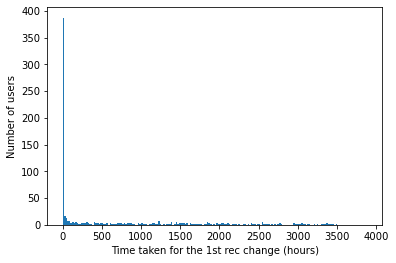

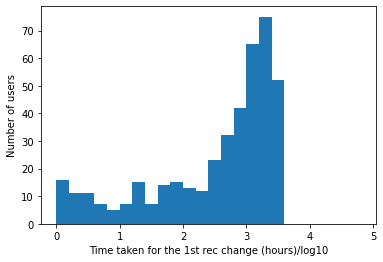

In [46]:
# plt.hist(tstamps_dict.values(), bins=[0, 500, 1000, 1500, 2000, 2500, 3000, 3500])
# plt.xlabel("Time taken for the 1st rec change (seconds)")
# plt.ylabel("Number of users")
# plt.show()

bins_list = []
for k in range(0, 3900, 20):
    bins_list.append(k)

plt.hist(tstamps_dict_alt.values(), bins=bins_list)
plt.xlabel("Time taken for the 1st rec change (hours)")
plt.ylabel("Number of users")
plt.show()

bins_list = []
k=0
while k<5:
    bins_list.append(k)
    k+=0.2

logs_list = []
for item in tstamps_dict_alt.values():
    logs_list.append(np.log10(item))

# print(len(logs_list))

# print(bins_list)
# print(min(tstamps_dict_alt.values()))
# print(max(tstamps_dict_alt.values()))
plt.hist(logs_list, bins= bins_list)
plt.xlabel("Time taken for the 1st rec change (hours)/log10")
plt.ylabel("Number of users")
plt.show()
# print(x)

query: all_logs

In [20]:
query_sessions = ''' SELECT userId, logJson, tstamp, action from ML3_mirror.log_action WHERE EXISTS 
                (SELECT userId from ML3_mirror.expt_user where expt_user.userId = log_action.userId 
                AND expt_user.exptId='listcmp-long' 
                AND expt_user.status='RANDOMLY_ASSIGNED')
                AND log_action.tstamp<'2015-04-01' AND log_action.tstamp>='2014-11-04' ORDER BY log_action.tstamp ''' 
all_logs = SSH_connection(query_sessions)
print(all_logs.shape[0])
all_logs.head()

#5m 35.9s
#4m 22.1s

connection done
621189


,userId,logJson,tstamp,action
0,251465,"{""pageName"":""restricted.listcmpLongIntro"",""par...",2014-11-04 14:53:16,pageview
1,251465,"{""pageName"":""base.frontpage"",""params"":{}}",2014-11-04 14:53:46,pageview
2,251465,"{""pageName"":""base.pickGroups"",""params"":{}}",2014-11-04 14:54:13,pageview
3,251465,"{""engineId"":""pick-groups""}",2014-11-04 14:55:18,recommender-change
4,251465,"{""pageName"":""base.frontpage"",""params"":{}}",2014-11-04 14:55:19,pageview


In [54]:
query_sessions = ''' SELECT la.userId, la.logJson, la.tstamp, la.action from ML3_mirror.log_action la INNER JOIN ML3_mirror.expt_user eu
                     ON eu.userId=la.userId WHERE eu.exptId='listcmp-long' AND eu.status='RANDOMLY_ASSIGNED' 
                     AND la.tstamp<'2015-04-01' AND la.tstamp>='2014-11-04' ORDER BY la.tstamp '''
all_logs = SSH_connection(query_sessions)
print(all_logs.shape[0])

connection done
621189


sesion_count()

In [51]:
def session_count(user_logs, tstamps_dict, fields):
    id_field = fields[0]
    time_field = fields[1]
    action_field = fields[2]

    sessions_dict = {}

    keys = tstamps_dict.keys()
    
    # key=userId, val=list; index+1 is the session number, value at index is the number of rec changes during that session
    # rec_changes_dict = dict.fromkeys(keys, [0]) 
    rec_changes_dict = {key:[0] for key in keys}

    for index,row in user_logs.iterrows():
        unique_id = row[id_field]
        action = row[action_field]

        diff = row[time_field] - tstamps_dict[unique_id]
        if diff.total_seconds() > 3600:
            sessions_dict[unique_id] = 1 + sessions_dict.get(unique_id, 1)
        else:
            sessions_dict[unique_id] = sessions_dict.get(unique_id, 1)
        
        if action == "recommender-change":
            session_num = sessions_dict[unique_id]
            val = rec_changes_dict[unique_id]
            
            if len(val) == session_num - 1:
                rec_changes_dict[unique_id].append(1)
            elif len(val)<session_num -1:
                val[len(val):session_num-1] = [0] * ((session_num)-len(val))
                val.append(1)
                rec_changes_dict[unique_id] = val
            else:
                rec_changes_dict[unique_id][session_num - 1] += 1

        tstamps_dict[unique_id] = row[time_field]
    
    rec_changes_dict = {key:val for key,val in rec_changes_dict.items() if len(val)>1 or val[0]!=0}

    return (sessions_dict, rec_changes_dict)

In [55]:
import statistics as st

In [60]:
dictionaries = session_count(all_logs, first_logs_alt_dict, ('userId', 'tstamp', 'action'))
recchanges = dictionaries[1]
sessions = dictionaries[0]

k=0
further_sessions = {}
for key,val in recchanges.items():
    if len(val)==1 :
        k += 1
        further_sessions[key] = sessions[key] - len(val)



In [62]:
# print(k)
print(round(k*100/748),"% of users only switched recommenders during their first session ")
print("Mean number of sessions after switch: ", round(st.mean(further_sessions.values())))
print("Median of number of sessions after switch: ", round(st.median(further_sessions.values())))
# print(len(recchanges))
# print(len(recchanges))
# print(dictionaries[2])

47 % of users only switched recommenders during their first session 
Mean number of sessions after switch:  8
Median of number of sessions after switch:  2


In [92]:
count = 0
k=0

start = time.time()
for val in recchanges.values():
    bools = [*map(bool, val)]
    if bools.count(True) == 2 or bools.count(True) == 1:
        count += 1
print("time: ", time.time()- start)

start_time = time.time()
count_new = 0
for val in recchanges.values():
    counter = 0
    for item in val:
        if item !=0:
            counter += 1
    if counter == 1:
        count_new += 1

print("time 2: ", time.time()-start_time)
print(count_new/748)




print(count/748)

time:  0.0006849765777587891
time 2:  0.0012280941009521484
0.6096256684491979
0.7967914438502673


In [82]:
booleans = [2,0,3]
# booleans = map(bool, booleans)
print(*map(bool, booleans))

True False True


In [93]:
# TEST
my_dict = {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]}
my_list = [0,1,2,3]

for item in my_list:
    if item == 1:
        my_dict[item][1] = item + 1

print(my_dict.items())


dict_items([(0, [0, 0]), (1, [0, 2]), (2, [0, 0]), (3, [0, 0])])


In [48]:
#TEST
start = time.time()
curr_tstamps = start_times_raw.set_index('userId').to_dict()['tstamp']
print("one liner: ", time.time() - start)

start = time.time()
start_tstamp_rows = start_times_raw.shape[0]
for k in range(start_tstamp_rows):
    userId = start_times_raw.loc[k].at['userId']
    start_tstamp = start_times_raw.loc[k].at['tstamp']
    curr_tstamps[userId] = start_tstamp
print("loop: ", time.time() - start)

one liner:  0.0068662166595458984
loop:  0.3140242099761963
